# Uber: Estimating Beta (SCL vs. Comparables)

#### Aidan Cremins, Peyton Lewis, Joe Morris, Amrit Sandhu

## Part I: SCL Analysis

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import ipywidgets as widgets
from ipywidgets import Text
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Assumptions

<li>Granularity: Weekly<br>
<li>Timeframe: Two years<br>
<li>Risk Free Rate: 0%

### Read in Data

In [2]:
uber_data = pd.read_csv('UBER.csv')

In [3]:
uber_data['Market Risk Premium'] = uber_data['Adj_Close_Market'].pct_change(1) - uber_data['rf_rate']
uber_data['Uber Risk Premium'] = uber_data['Adj_Close_Uber'].pct_change(1) - uber_data['rf_rate']
uber_data = uber_data.fillna(0)
uber_data.head(5)

,Adj_Close_Uber,Adj_Close_Market,rf_rate,MRP,URP,Market Risk Premium,Uber Risk Premium
0,34.459999,319.331451,0,0.000000,0.000000,0.000000,0.000000
1,37.720001,324.295410,0,0.015545,0.094602,0.015545,0.094602
2,37.270000,336.933502,0,0.038971,-0.011930,0.038971,-0.011930
3,33.720001,337.360901,0,0.001268,-0.095251,0.001268,-0.095251
4,36.750000,335.894012,0,-0.004348,0.089858,-0.004348,0.089858


In [4]:
#define predictor and response variables
y = uber_data['Uber Risk Premium'].iloc[1:]
x = uber_data['Market Risk Premium'].iloc[1:]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Uber Risk Premium   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     37.41
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.60e-08
Time:                        21:58:22   Log-Likelihood:                 135.59
No. Observations:                 109   AIC:                            -267.2
Df Residuals:                     107   BIC:                            -261.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0016    

### Beta Analysis

In [5]:
uber_beta = model.params[1]
uber_tstat_0 = model.tvalues[1]
uber_se = model.bse[1]

To test whether the coeffient is statistically signicantly different from the market's Beta of 1, we run a Hypothesis Test with the null hypothesis that Uber's Beta is equal to 1.

In [6]:
uber_t_stat = (uber_beta - 1) / uber_se
uber_t_stat

2.2619451535403217

Because the relevant t statisitc is 2.269 and there are enough data points (n = 109) to assume that the Student T Distribution is well-approximated by the Normal curve, a critical t value of 1.96 is used. This indicates that Uber's Beta is statisically different from the market Beta of 1 and therefore carries more risk than a well diversified portfolio.

### Confidence Interval of Beta

In [7]:
lower_bound = uber_beta - 1.96 * uber_se
upper_bound = uber_beta + 1.96 * uber_se
print(lower_bound, upper_bound)

1.078343291585563 2.0954343076677153


When computing the upper and lower bound on the Beta estimate for Uber using the critical t-value of 1.96, the bound is found to be (1.0783, 2.0954), which differs slightly from the OLS output, which interpolated the exact critical t-statistic using the sample size (instead of approximating with the Normal curve). This 95% confidence interval was computed by taking the product of the critical t-value of 1.96 and the standard error of the Beta estimate of 0.259 and adding and subtracting it from the Beta estimate of 1.5869 (Confidence interval = Beta +- t_critical * standard error of Beta). The critical t value of 1.96 is used because in a normal distribution, 95% of the area under the curve is contained within 1.96 standard deviations on either side of the mean. This will allow us to obtain a 95% confidence interval on our Beta estimate for Uber. <br><br>
This interval, centered at the Beta estimate for Uber, indicates that if this process were repeated many times, 95% of the generated estimates for Uber's Beta would fall within this interval. This Beta was computed using weekly returns for two years. This level of granularity provides a sample size of 109 data points, which would lead to a much tighter interval around Beta than 2 years of monthly returns, for example. This is a function of the sample size, because as sample size increases, the standard error of the Beta estimate decreases, and its corresponding confidence interval will tighten as well.

### Security Characteristic Line

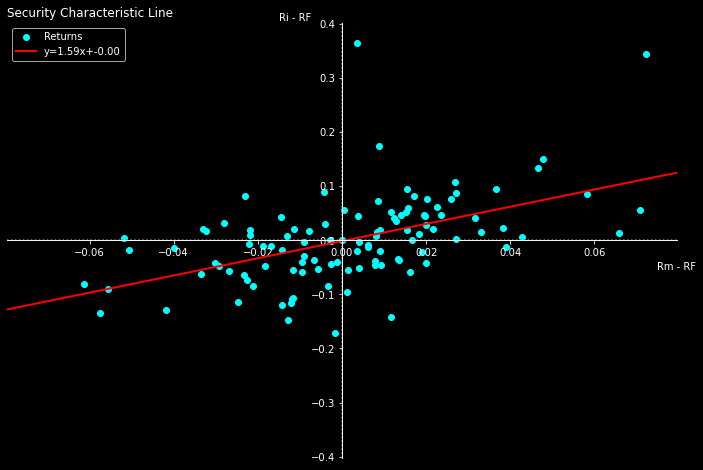

In [8]:
x = uber_data['Market Risk Premium']
y_actual = uber_data['Uber Risk Premium']
    
x_all = np.linspace(-4, 4, 100)
y = model.params['const'] + model.params['Market Risk Premium'] * x_all


x_range = max(abs(max(x)), abs(min(x))) + max(abs(max(x)), abs(min(x))) * .1
y_range = max(abs(max(y_actual)), abs(min(y_actual))) + max(abs(max(y_actual)), abs(min(y_actual))) * .1
max_range = max(x_range, y_range)

plt.style.use('dark_background')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.yaxis.set_label_coords(.53, 1)
ax.xaxis.set_label_coords(1, .53)
plt.scatter(x=x, y=y_actual, label='Returns', color='cyan')
plt.plot(x_all, y, color='red', linewidth=2, \
    label='y={:.2f}x+{:.2f}'.format(model.params['Market Risk Premium'],model.params['const']))
plt.axhline(0, linestyle=':', color='grey')
plt.axvline(0, linestyle=':', color='grey')
plt.xlabel('Rm - RF')
ax.xaxis.set_label_coords(1, 0.45)
plt.ylabel('Ri - RF', rotation = 360)
ax.yaxis.set_label_coords(0.43, 1)
plt.xlim(-x_range, x_range)
plt.ylim(-y_range, y_range)
plt.legend(loc='best')
plt.title('Security Characteristic Line ', loc='left')
    
plt.show()
    

## Part II: Comparables Analysis

Uber has 3 Business Segments: <br><br>
<li>Freight<br>
<li>Food Delivery<br>
<li>Ride Sharing<br>
    
<br><br>
For each of the segments, we identified 7 Comparables. They are listed below in their relative sections. <br>

### Segment I: Freight

<br>
Comps: 
<li>
<li>
<li>
<li>
<li>
<li>
<li>

### Segment II: Food Delivery

<br>
Comps: 
<li>
<li>
<li>
<li>
<li>
<li>
<li>

### Segment III: Ride Sharing

<br>
Comps: 
<li>
<li>
<li>
<li>
<li>
<li>
<li>